In [ ]:
%pip install contextily # to give background
%pip install geopandas
%pip install shapely
!apt install python3-rtree 

In [ ]:
import geopandas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shapely.wkt
import contextily as ctx


# import data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# import the japanese desition buying cars df and sort by lat
df = pd.read_table('/content/drive/My Drive/tl_2019_us_zcta510/Interdependent.dat',sep='\s+')
df = df.sort_values(by='lat').reset_index(drop=True)
df.head()

In [ ]:
# import the US zip codes boundries shapefile
shp = geopandas.read_file('/content/drive/My Drive/tl_2019_us_zcta510/tl_2019_us_zcta510.shp')

In [ ]:
df_shp = shp.copy()

In [ ]:
# drop useless columns and rename the usefull ones
df_shp = df_shp[['ZCTA5CE10','INTPTLAT10', 'INTPTLON10', 'geometry']]
df_shp.columns = ['zip','lat','lon','geometry']

#change lat, lon to float
df_shp['lat'] = df_shp['lat'].apply(lambda row: float(row[1:]))
df_shp['lon'] = df_shp['lon'].apply(lambda row: float(row))
df_shp['zip'] = df_shp['zip'].apply(lambda row: int(float(row)))

# sort by lat
df_shp = df_shp.sort_values(by='lat').reset_index(drop=True)

# verify and check the crs
print(df_shp.info())
print(df_shp.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33144 entries, 0 to 33143
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zip       33144 non-null  int64   
 1   lat       33144 non-null  float64 
 2   lon       33144 non-null  float64 
 3   geometry  33144 non-null  geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 1.0 MB
None
epsg:4269


In [ ]:
# leave only the lat between the max and the min lat of df.
# Because we are working with boundries we gave much space to the plot so later we can color boundries.
# print(max(df['lat']),min(df['lat']),max(df['long']),min(df['long']))
# 34.48 32.58 -116.75 -118.83

cmaxlat = df_shp['lat']<= 34.75 #max(df['lat'])
cminlat = df_shp['lat'] >= 32.00 #min(df['lat'])

cmaxlon = df_shp['lon']<= -116.50 #max(df['long'])
cminlon = df_shp['lon'] >= -119.0 #min(df['long'])

cali = df_shp[(cminlat) & (cmaxlat) & (cmaxlon) & (cminlon)].reset_index(drop=True)
cali_df = cali.to_crs(epsg=3857)

In [ ]:
# merge the 2 df and convert to gdf with src = 3857 so we can have a real background
df_merge = pd.merge(df,
         cali_df[['zip','geometry']],
         left_on = 'zip', right_on='zip',
         how='left')
final_df = geopandas.GeoDataFrame(df_merge,crs ='EPSG:3857',geometry=df_merge['geometry'])

In [ ]:
final_df.head()

zip    lat  ...  education                                           geometry
0  91932  32.58  ...    32.4213  POLYGON ((-13039437.831 3840429.705, -13039317...
1  91932  32.58  ...     9.6715  POLYGON ((-13039437.831 3840429.705, -13039317...
2  91932  32.58  ...    20.7592  POLYGON ((-13039437.831 3840429.705, -13039317...
3  91932  32.58  ...    32.4213  POLYGON ((-13039437.831 3840429.705, -13039317...
4  91932  32.58  ...     9.6715  POLYGON ((-13039437.831 3840429.705, -13039317...

[5 rows x 11 columns]

Análisis Espacial.


4. Describirlos en la tesis.
5. Hacer un plot de correlación de las variables iniciales y decir a correlación del estudio y el nivel de ingresos
6. Mencionar la relacion de precio y el optional en ambos casos(y=1, y=0).
7. Mencionar la edad promedio y que relacion tiene eso con la compra de autos japonenes.
8. Mencionar el bajo porcentaje de personas de origen japones(etnicidad) que están dentro del estudio.


In [ ]:
# Cut the plot in two, so we can see better the distrubution of the consumers.
def cut_plot(gdf):
  df1 = gdf[(gdf['lat'] > 33)]
  df2 = gdf[(gdf['lat'] <= 33.00)]
  return(df1,df2)

cali1,cali2=cut_plot(final_df)

In [ ]:
# zips df is only to show with which zip codes we are working.
zips = final_df[['zip','geometry']].drop_duplicates(subset=['zip'])
c2zip = cali2[['zip','geometry']].drop_duplicates(subset=['zip'])
c1zip = cali1[['zip','geometry']].drop_duplicates(subset=['zip'])

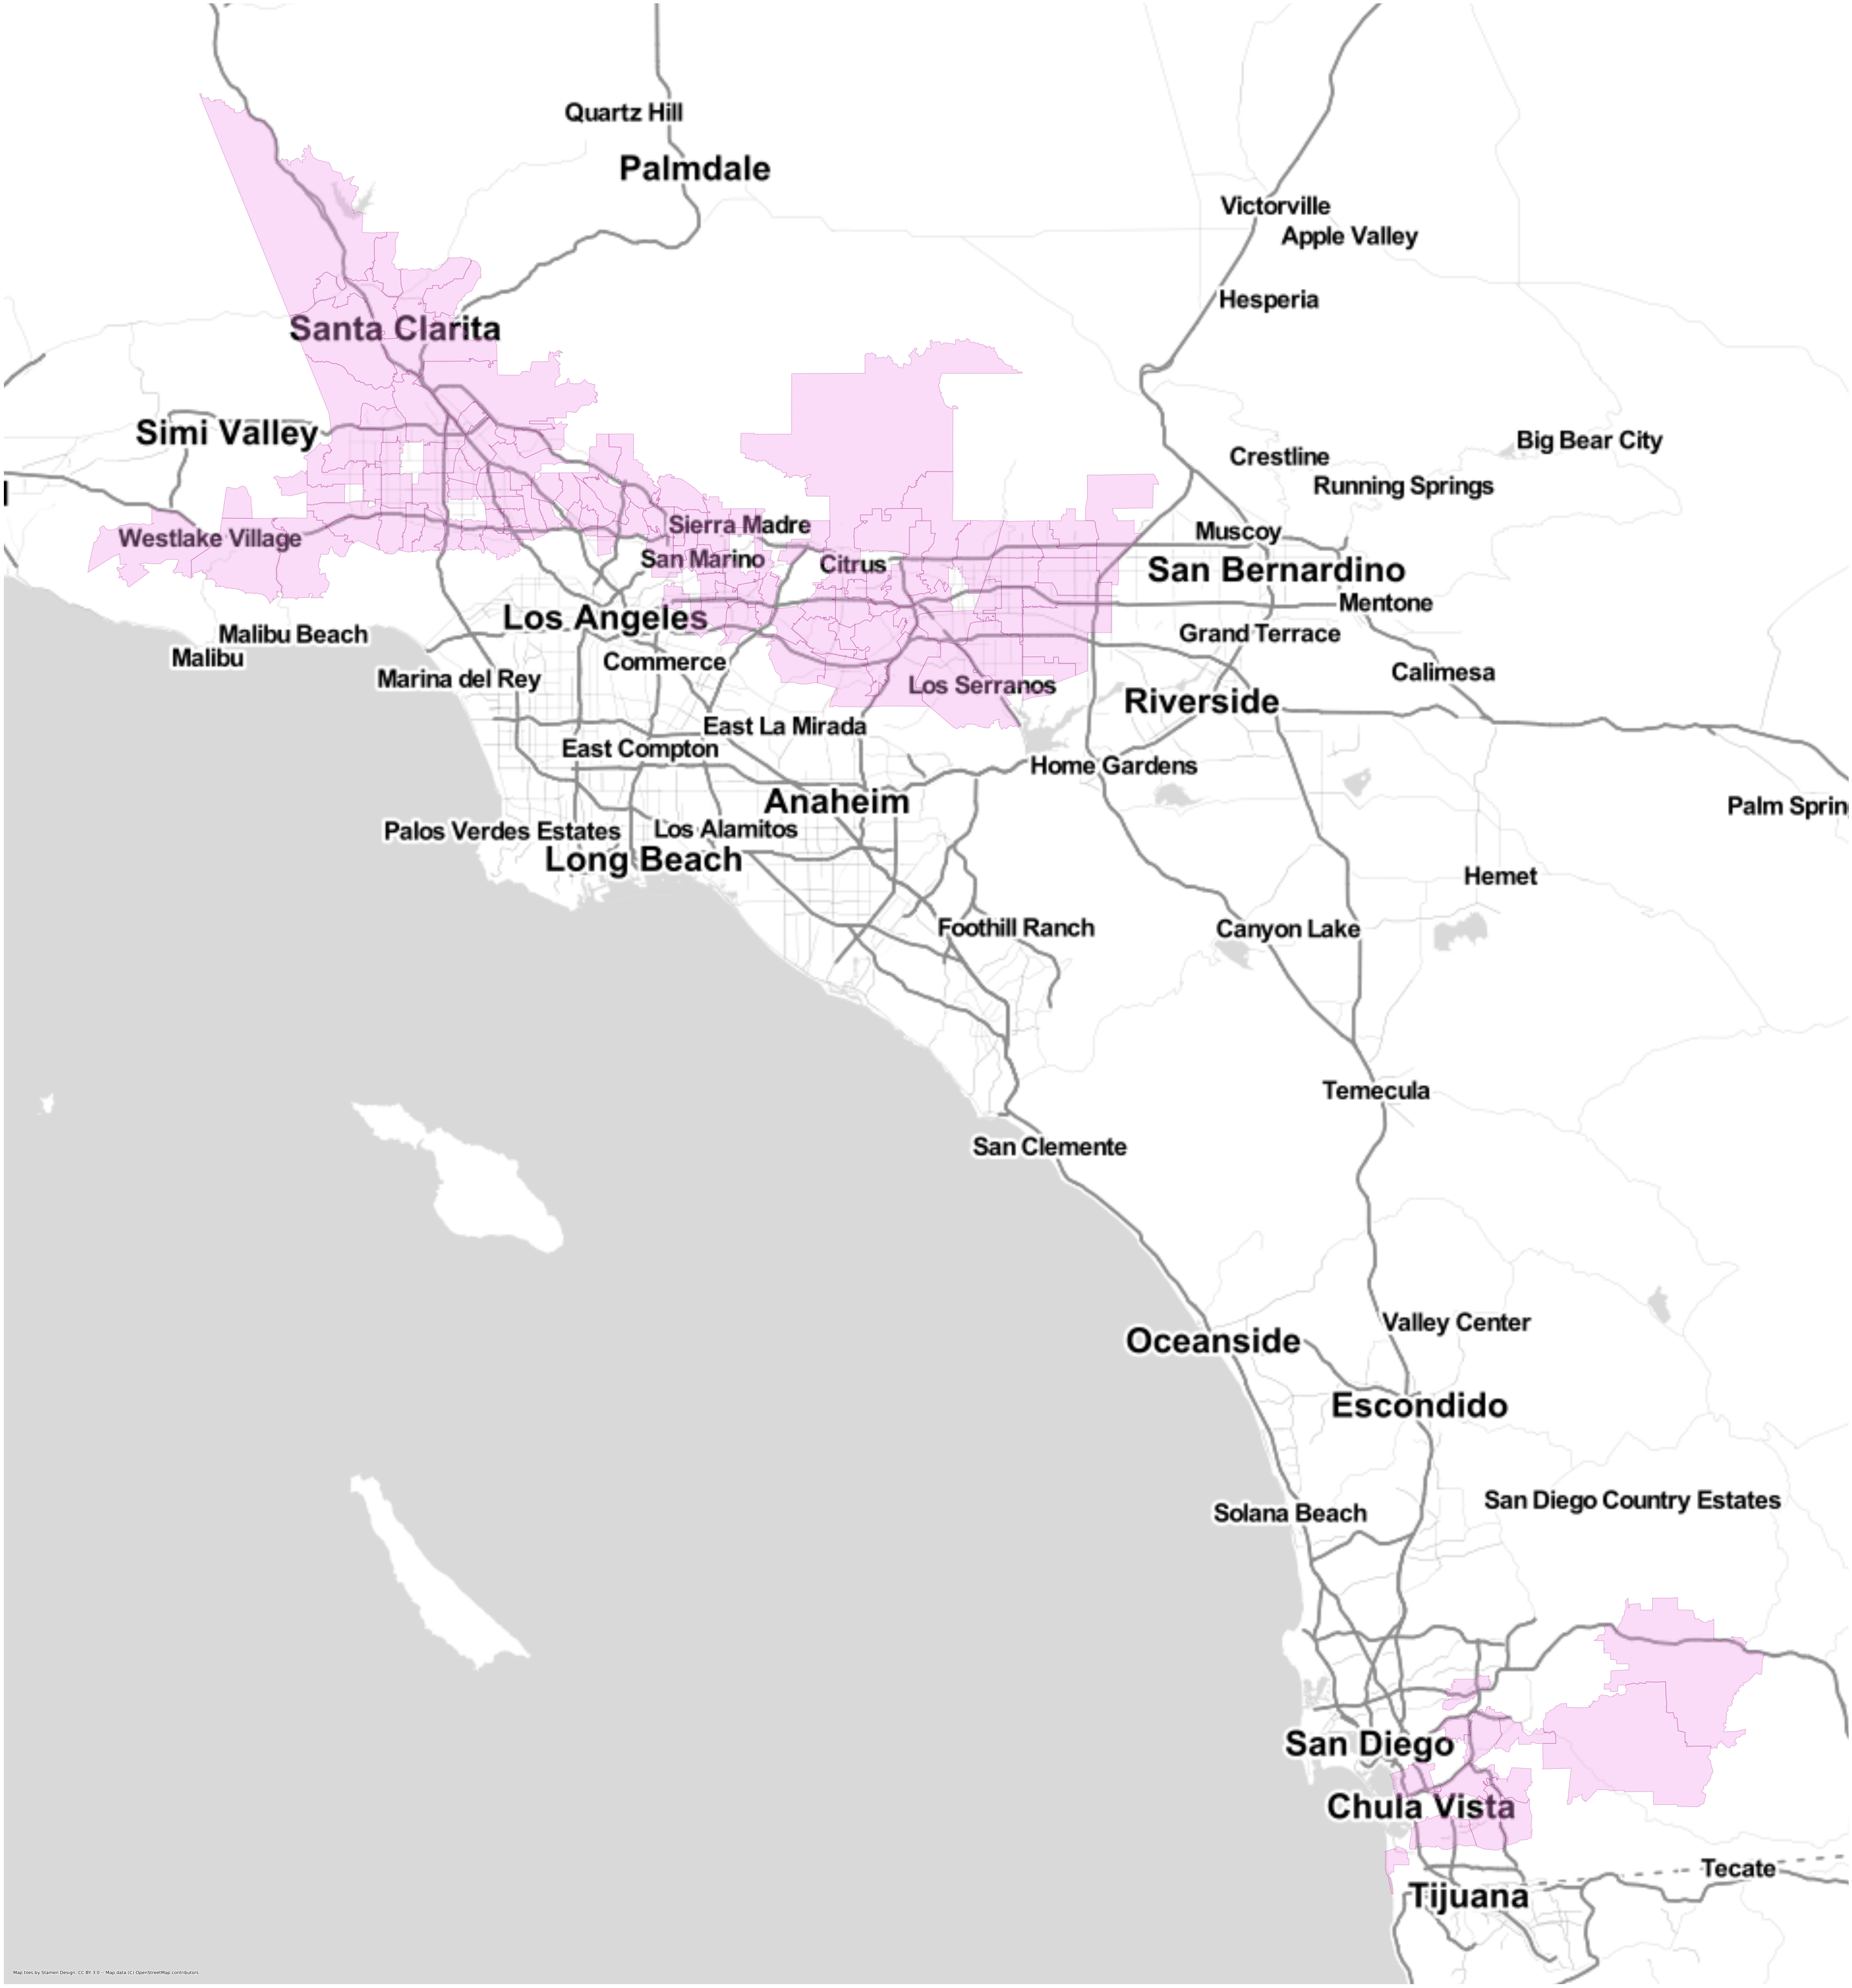

In [ ]:
# plots
# Initialize our plot
fig, ax = plt.subplots(figsize=(50,50))
# Plot our SF GeoDataFrame
zips.plot(ax=ax,alpha=0.3, color = '#F58DEA',edgecolor = '#93027A')
# Add in a background using contextily
ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
# Turn off axis
ax.set_axis_off()
fig.tight_layout()
plt.savefig('cali_pink.p')

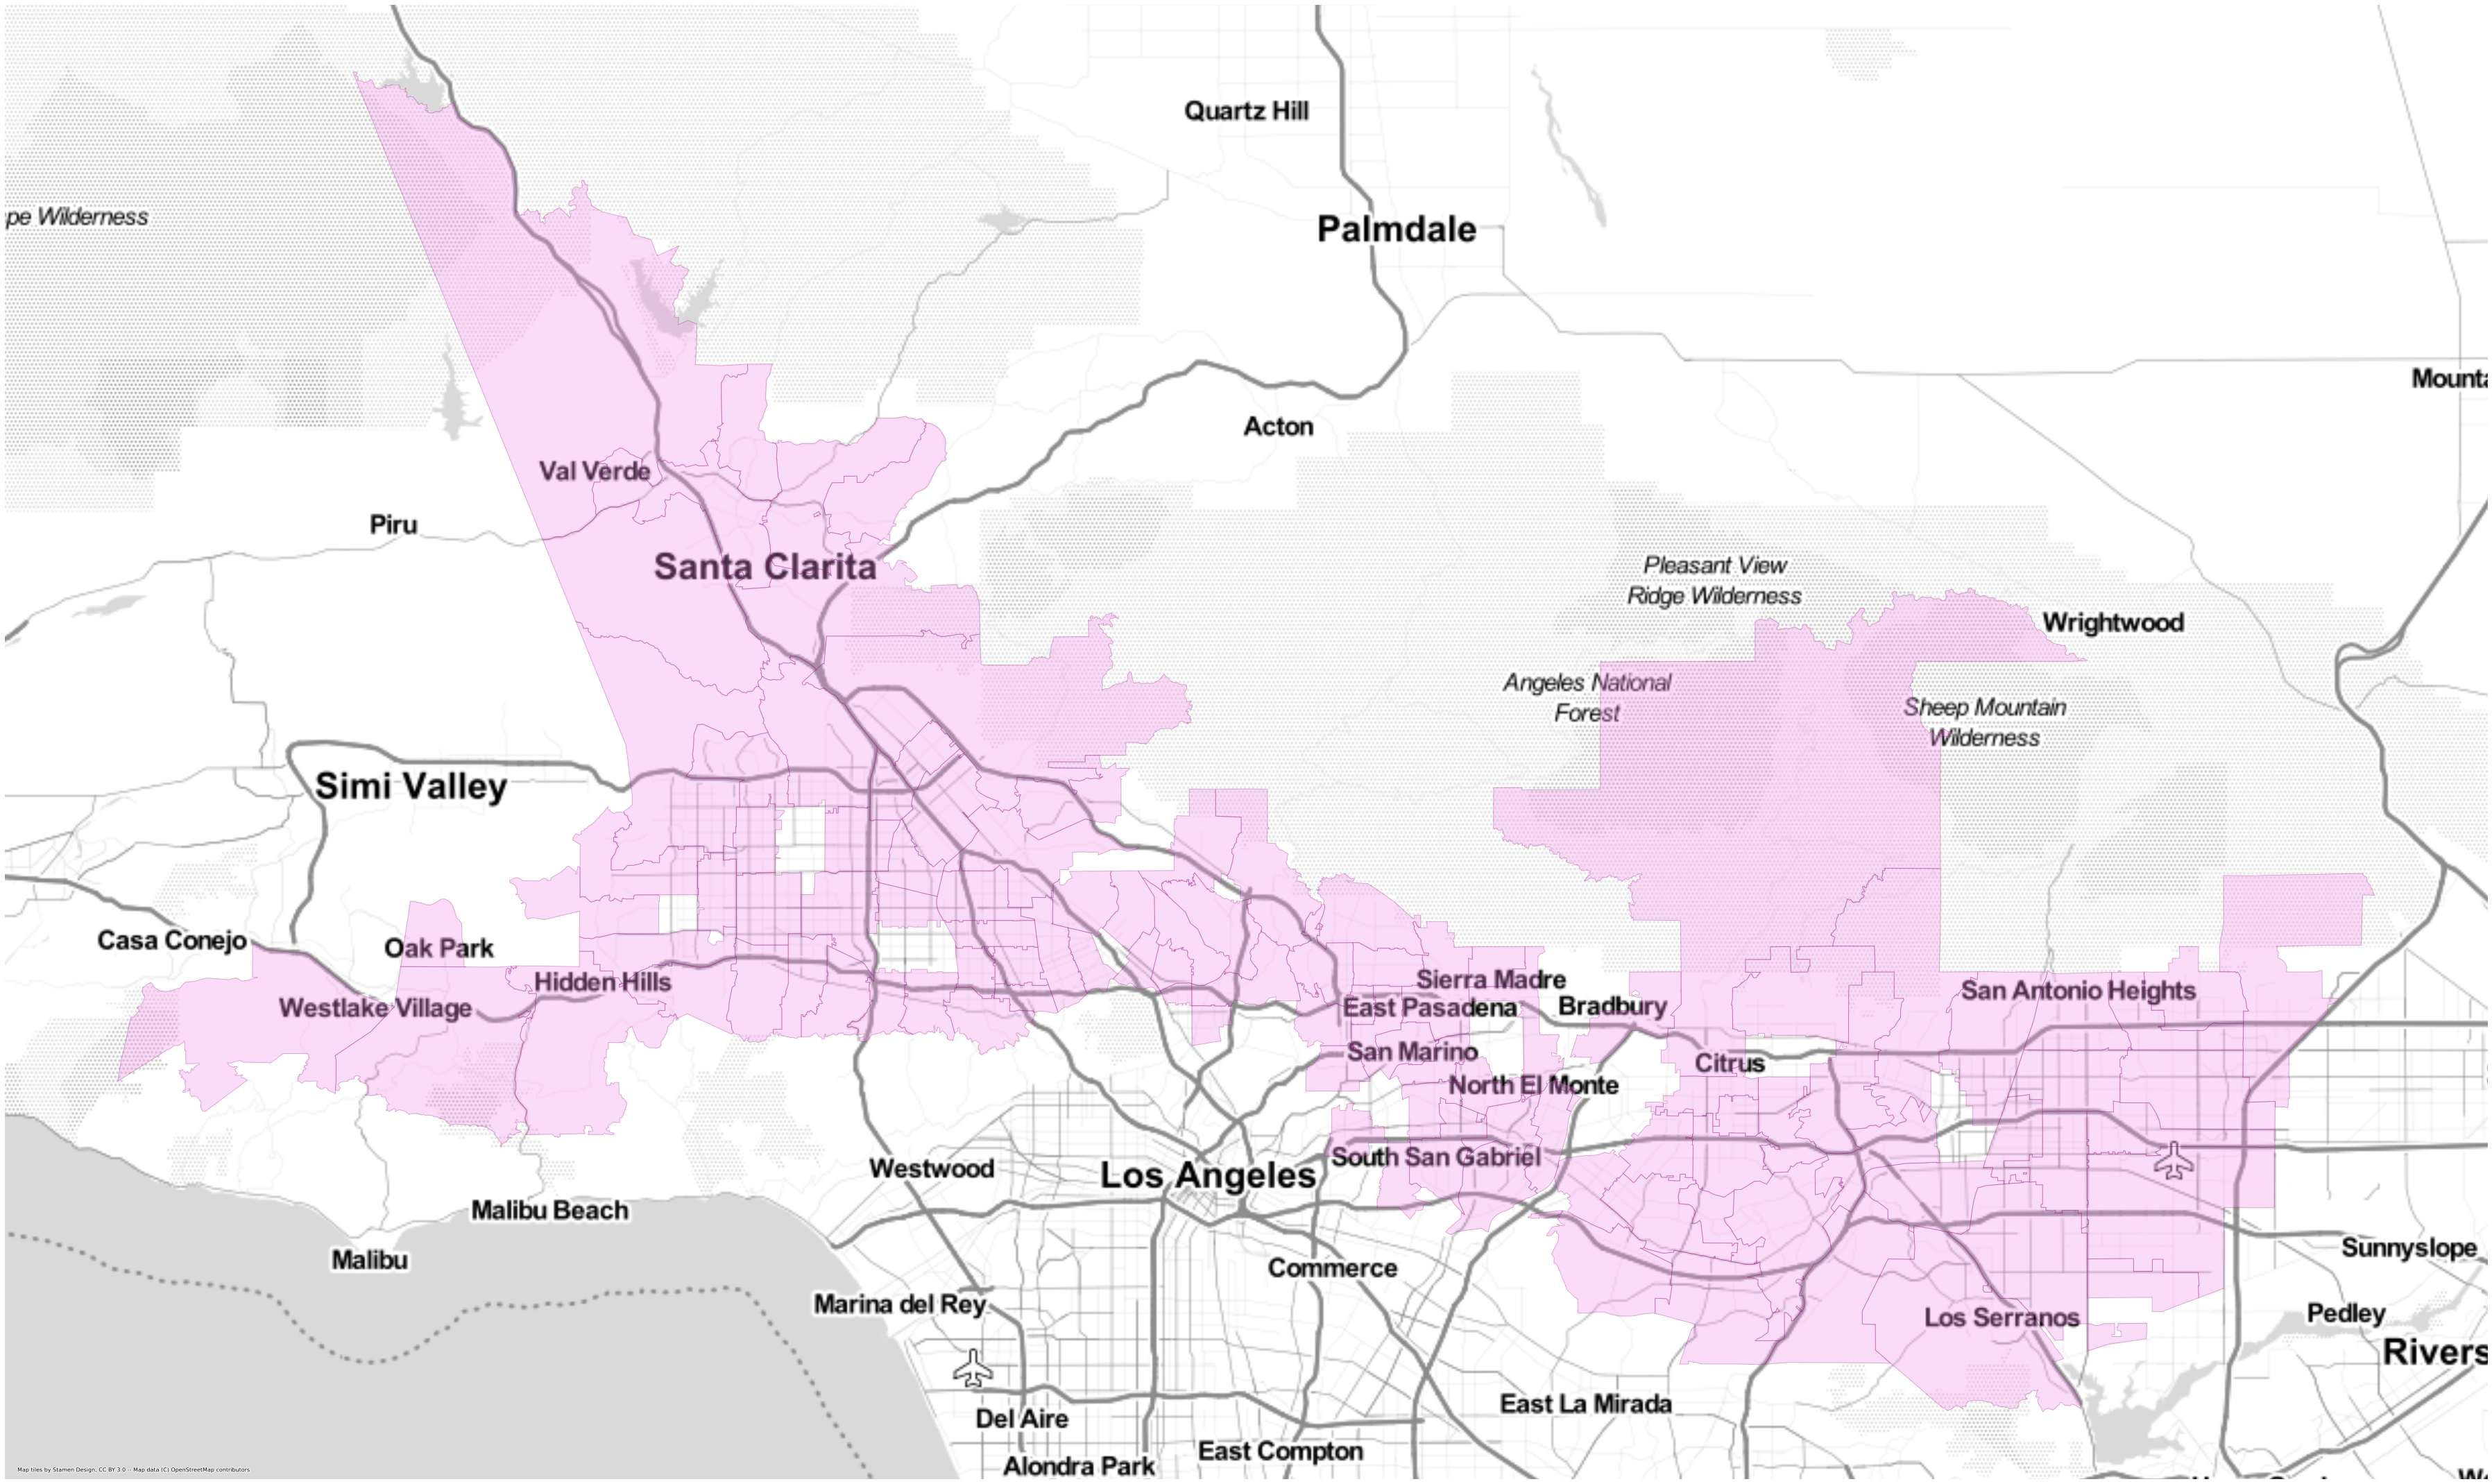

In [ ]:
# plots
# color = '#E2B1F0',edgecolor = '#D42FA2' PINK
# Initialize our plot
fig, ax = plt.subplots(figsize=(50,50))
# Plot our SF GeoDataFrame
c1zip.plot(ax=ax,alpha=0.3, color = '#F58DEA',edgecolor = '#93027A')
# Add in a background using contextily
ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
# Turn off axis
ax.set_axis_off()
fig.tight_layout()
#plt.savefig('cali1_pink.pdf')

In [ ]:
#concentration of japanese buyers in each zipcode

df_j = final_df[['zip','y']].groupby('zip')
tot_zip = df_j.count()
jap = pd.concat([df_j.count(),df_j.sum()],axis=1)
jap.columns = ['tot','jap']
jap['nonjap'] = jap['tot']-jap['jap']
jap['jap_perc'] = (jap['jap']/jap['tot'])*100
jap['nonjap_perc'] = jap['nonjap']/jap['tot']
jap = jap.reset_index()

# merge the 2 df and convert to gdf with src = 3857 so we can have a real background
jap_merge = pd.merge(jap,
         cali_df,
         left_on = 'zip', right_on='zip',
         how='left')
jap_final = geopandas.GeoDataFrame(jap_merge,crs ='EPSG:3857',geometry=jap_merge['geometry'])
jap_final.head(5)

zip  tot  ...         lon                                           geometry
0  91001    9  ... -118.138263  POLYGON ((-13154807.348 4054260.780, -13154798...
1  91006    9  ... -118.026704  MULTIPOLYGON (((-13136763.460 4042367.767, -13...
2  91010    3  ... -117.957627  POLYGON ((-13135648.929 4044612.794, -13135636...
3  91011    7  ... -118.205306  POLYGON ((-13162294.474 4064721.511, -13162251...
4  91024    7  ... -118.050216  POLYGON ((-13143292.014 4052048.694, -13143280...

[5 rows x 9 columns]

In [ ]:
jap1,jap2=cut_plot(jap_final)

In [ ]:
# PuRd, ocean
cm = sns.color_palette("RdPu", as_cmap=True)
fig, ax = plt.subplots(figsize=(50,50))
jap1.plot(ax=ax,column='jap_perc',legend=True, cmap = cm,
          legend_kwds={'orientation': "horizontal"})
ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
fig.tight_layout()
#plt.savefig('jap1.pdf')

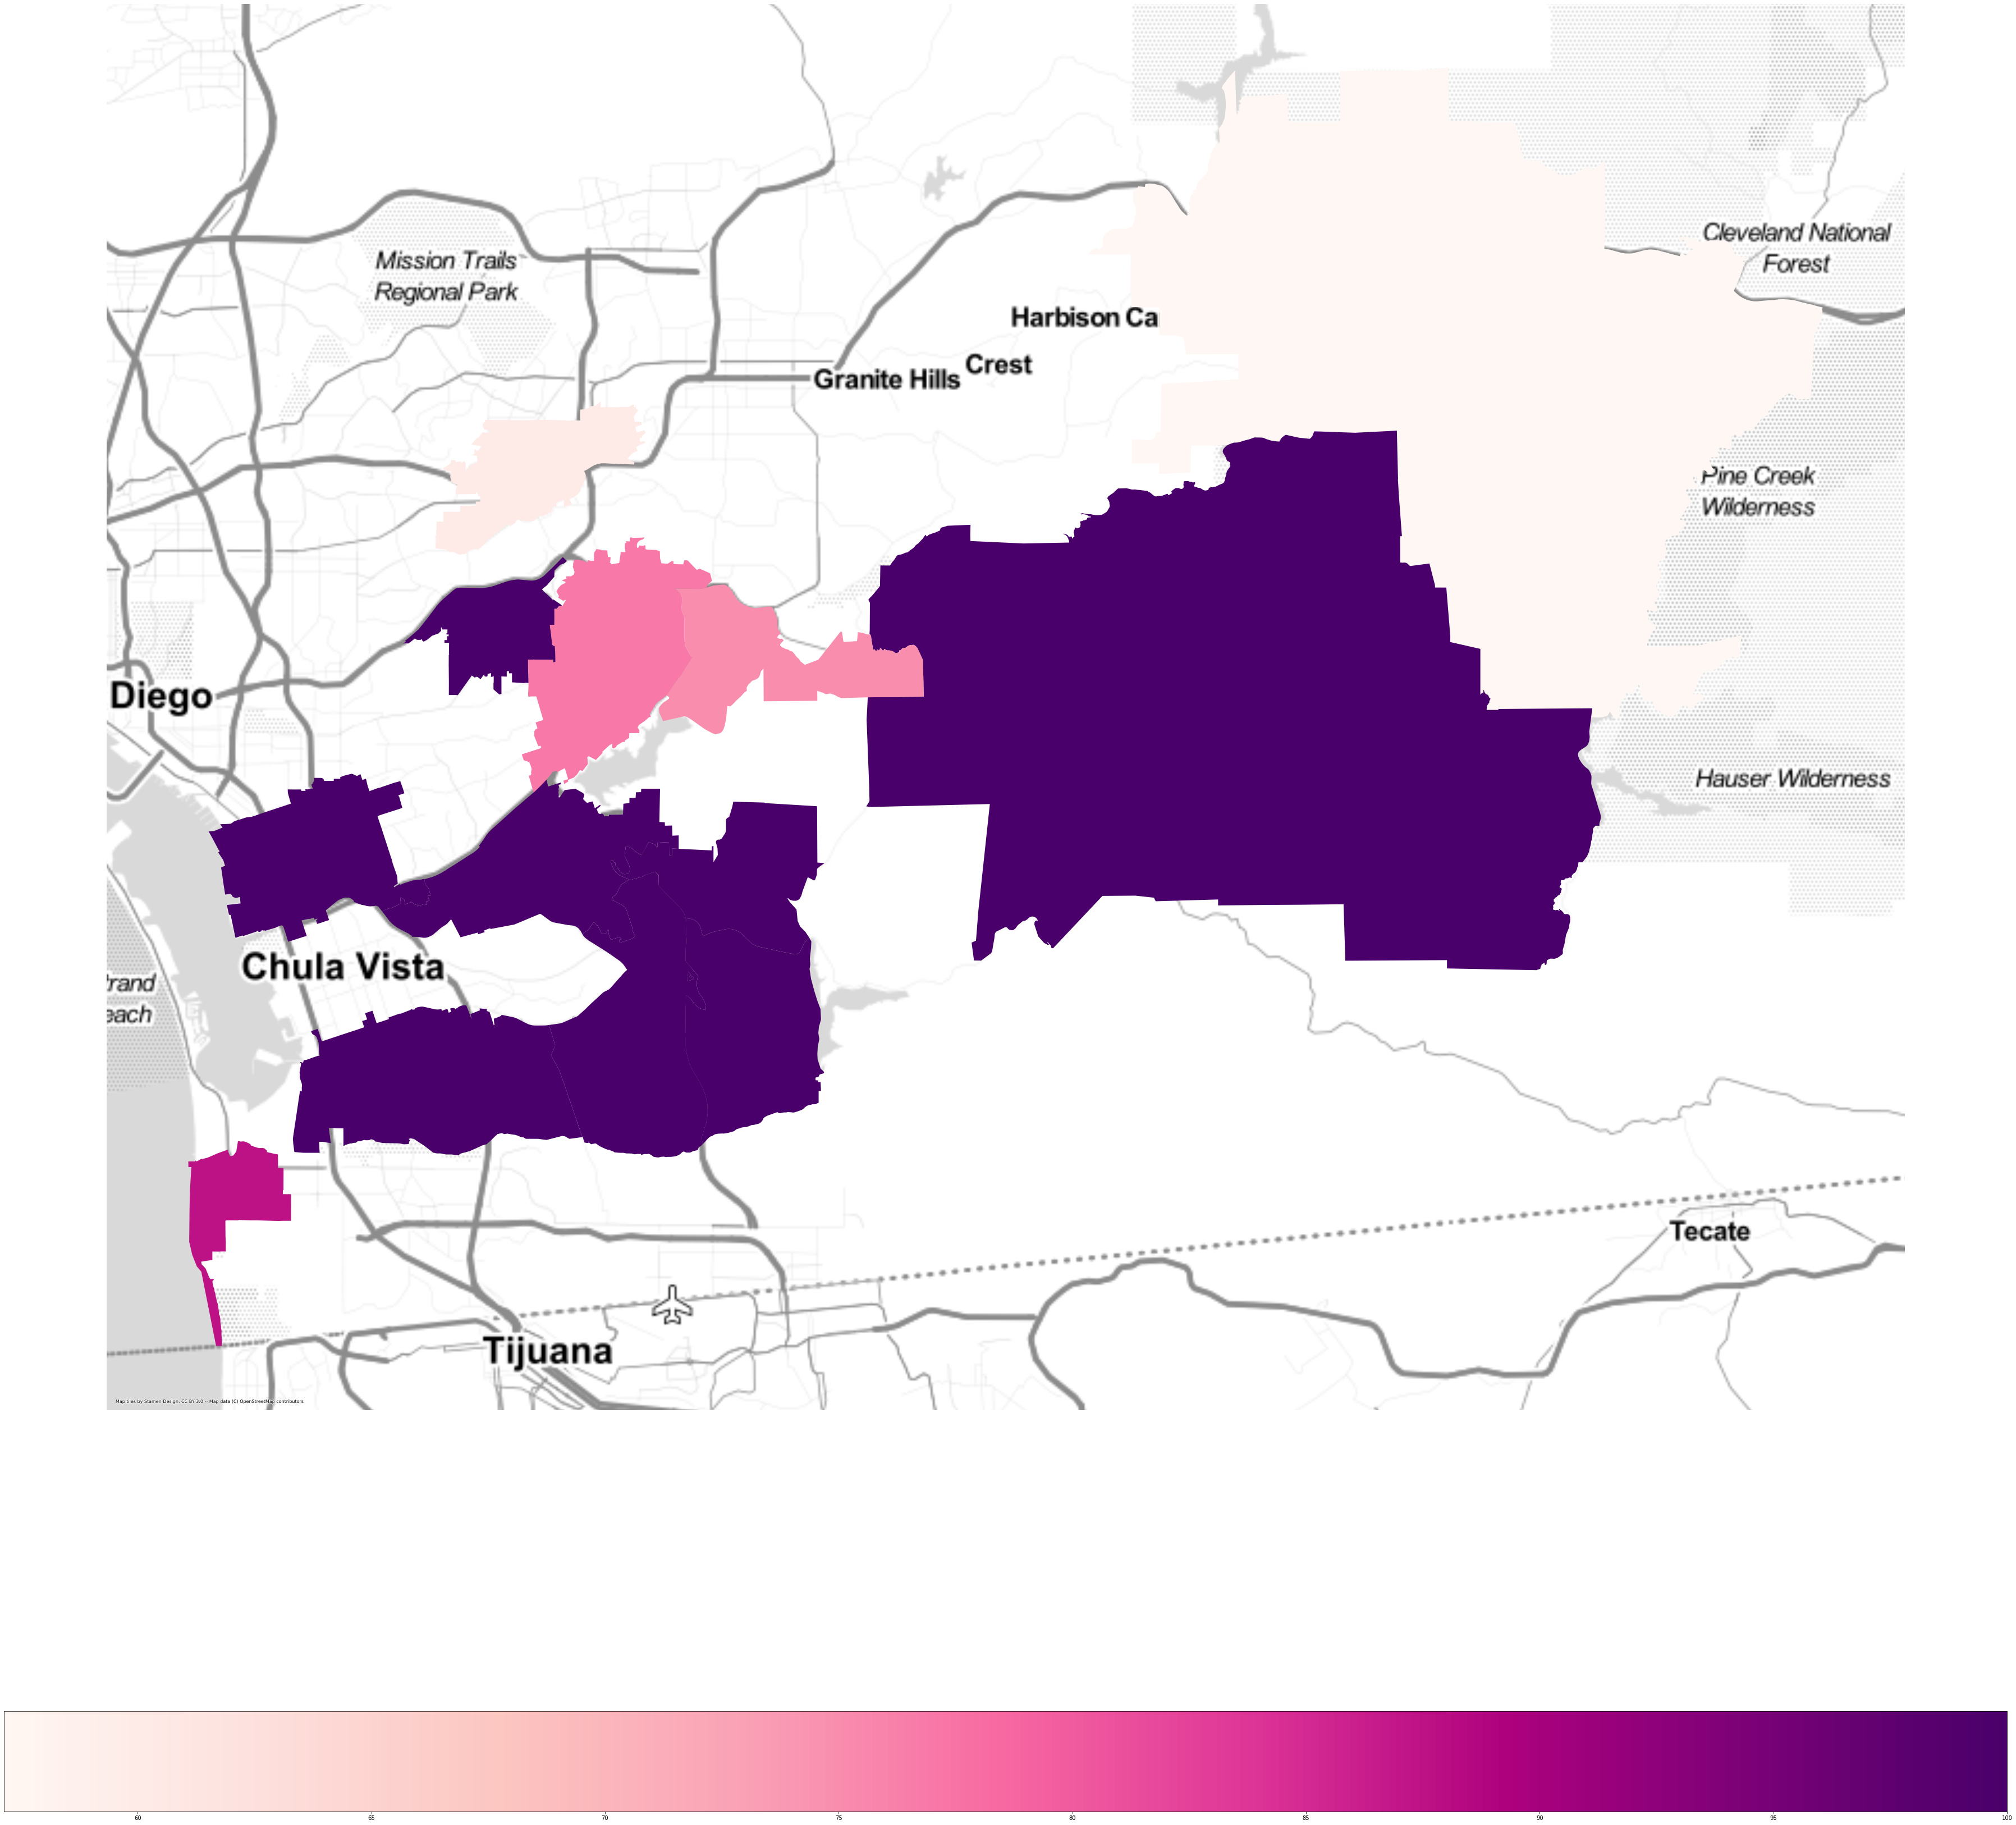

In [ ]:
fig, ax = plt.subplots(figsize=(50,50))
jap2.plot(ax=ax,column='jap_perc',legend=True, cmap = cm,
          legend_kwds={'orientation': "horizontal"})
ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
fig.tight_layout()
#plt.savefig('jap2.pdf')